In [117]:
import pandas as pd

#load combined csv
final_combined = pd.read_csv("data/final_combined.csv", parse_dates=["timestamp"])
final_combined.head()

,timestamp,price,tweet_id,handle,ticker,sentiment_label,sentiment_score,top_topic,Technology,Healthcare and Pharmaceuticals,Defense and Aerospace,Financials,Airlines and Travel,Energy,Agriculture,Automotive,minutes_since_tweet
0,2020-05-27 13:40:00,63.373416,1265646238768209920,@SenWarren,JPM,Neutral,0.963891,Technology,0.009989,0.000249,0.000902,0.000512,0.000088,0.008489,0.000305,0.001025,-29.20915
1,2020-05-27 13:41:00,62.264346,1265646238768209920,@SenWarren,JPM,Neutral,0.963891,Technology,0.009989,0.000249,0.000902,0.000512,0.000088,0.008489,0.000305,0.001025,-28.20915
2,2020-05-27 13:42:00,99.650077,1265646238768209920,@SenWarren,JPM,Neutral,0.963891,Technology,0.009989,0.000249,0.000902,0.000512,0.000088,0.008489,0.000305,0.001025,-27.20915
3,2020-05-27 13:43:00,63.437362,1265646238768209920,@SenWarren,JPM,Neutral,0.963891,Technology,0.009989,0.000249,0.000902,0.000512,0.000088,0.008489,0.000305,0.001025,-26.20915
4,2020-05-27 13:44:00,63.378044,1265646238768209920,@SenWarren,JPM,Neutral,0.963891,Technology,0.009989,0.000249,0.000902,0.000512,0.000088,0.008489,0.000305,0.001025,-25.20915


In [118]:
#load VIX data
vix_data = pd.read_csv('data/VIX1.csv')
vix_data['DATE'] = pd.to_datetime(vix_data['DATE'], format='%m/%d/%y')

vix_data.head()

,DATE,AVG VIX
0,1990-01-02,17.24
1,1990-01-03,18.19
2,1990-01-04,19.22
3,1990-01-05,20.11
4,1990-01-08,20.26


# **Calculate Volatility and Weighted Volatility** (based on price change spikes)

Calculate volatility using rolling standard deviation of log returns, grouped by ticker and tweet_id

Calculate weighted volatility based on price change spikes

In [119]:
import pandas as pd
import numpy as np

def calculate_grouped_volatility(df, vix_data, window_size=30, price_column='price', timestamp_column='timestamp'):

    df[timestamp_column] = pd.to_datetime(df[timestamp_column])
    df.sort_values(timestamp_column, inplace=True)

    #calculate log return
    df['log_return'] = np.log(df[price_column] / df[price_column].shift(1))

    #calculate rolling standard deviation (volatility) for each group (ticker, tweet_id)
    df['volatility'] = df.groupby(['ticker', 'tweet_id'])[price_column].rolling(window=window_size, min_periods=1).std().reset_index(level=[0, 1], drop=True)
    df.dropna(subset=['volatility'], inplace=True)

    df['price_change_pct'] = df[price_column].pct_change(fill_method=None) * 100  # Calculate price change percentage

    #calculate average volatility by ticker
    average_volatility = df.groupby('ticker')['volatility'].mean()  # Average volatility for each ticker
    df['average_volatility'] = df['ticker'].map(average_volatility)

    # threshold for price spikes
    price_spike_threshold = 5.0
    df['price_spike'] = df['price_change_pct'].apply(lambda x: 1 if abs(x) >= price_spike_threshold else 0)

    # merge VIX data
    df['date'] = df[timestamp_column].dt.date
    vix_data['DATE'] = pd.to_datetime(vix_data['DATE'], format='%m/%d/%y')
    vix_data['DATE'] = vix_data['DATE'].dt.date  # Ensure the date format matches

    df = pd.merge(df, vix_data[['DATE', 'AVG VIX']], left_on='date', right_on='DATE', how='left')

    #calculate weighted volatility based on price spikes and VIX
    def calculate_weighted_volatility(row):
        if row['price_spike'] == 1:
            avg_vol = row['average_volatility']
            weight_factor = 1 + (avg_vol - row['volatility']) * 10  # Adjust weight factor based on volatility
            vix_factor = row['AVG VIX'] / 20  # Normalize VIX for weighting (assuming VIX is scaled around 20)
            return row['volatility'] * weight_factor * vix_factor
        else:
            return row['volatility']


    df['weighted_volatility'] = df.apply(calculate_weighted_volatility, axis=1)

    #fill NaN values in 'weighted_volatility' with the original 'volatility' value
    df['weighted_volatility'] = df['weighted_volatility'].fillna(df['volatility'])

    # If no price change, set the price change percentage to 0
    df['price_change_pct'] = df['price_change_pct'].fillna(0)

    return df


In [120]:
volatility_df = calculate_grouped_volatility(final_combined, vix_data)
print(volatility_df[['timestamp', 'ticker', 'price', 'volatility', 'price_change_pct', 'weighted_volatility', 'AVG VIX']].head())

            timestamp ticker      price  volatility  price_change_pct  \
0 2016-12-05 12:15:00   WYNN  99.002000    0.017418          0.000000   
1 2016-12-05 12:15:00    FOX  27.458544    0.004898        -72.264657   
2 2016-12-05 12:15:00    LVS  61.312195    0.016306        123.290042   
3 2016-12-05 12:15:00    MGM  29.001725    0.007139        -52.698277   
4 2016-12-05 12:16:00   WYNN  98.930269    0.036447        241.118569   

   weighted_volatility  AVG VIX  
0             0.017418    12.95  
1             0.004884    12.95  
2             0.022054    12.95  
3             0.007203    12.95  
4             0.090791    12.95  


# Compute Alt-A and Alt-B

In [121]:
import re

# build a handle mask (no regex‑groups warning)
handle_regex = r'(?:realDonaldTrump|DonaldJTrump|DonaldTrump|trump)'
trump_mask   = volatility_df['handle'].str.contains(handle_regex, flags=re.I, na=False)
#print("Trump tweets in volatility_df:", trump_mask.sum())

In [122]:
#Baseline leaderboard (current weighted_volatility)  – reference only

baseline = (volatility_df
            .groupby('tweet_id', as_index=False)
            .agg({'weighted_volatility':'max',
                  'handle':'first',
                  'timestamp':'first',
                  'ticker':lambda s: ', '.join(sorted(s.unique()))})
            .rename(columns={'weighted_volatility':'score'})
            .sort_values('score', ascending=False)
            .reset_index(drop=True)
            .head(100))

trump_top = baseline['handle'].str.contains(handle_regex, flags=re.I, na=False).sum()
print("Trump in current top‑100:", trump_top)

Trump in current top‑100: 0


In [123]:
# Alt‑A  (ticker Z‑score × capped VIX)
df_alt = volatility_df.copy()

mu  = df_alt.groupby('ticker')['volatility'].transform('mean')
sd  = df_alt.groupby('ticker')['volatility'].transform('std').replace(0, np.nan)
df_alt['vol_z']      = (df_alt['volatility'] - mu) / sd
df_alt['vix_factor'] = ((df_alt['AVG VIX'] - 15) / 15 + 1).clip(1, 2)
df_alt['score']      = df_alt['vol_z'] * df_alt['vix_factor']

altA = (df_alt
        .groupby('tweet_id', as_index=False)
        .agg({'score':'max',
              'handle':'first',
              'timestamp':'first',
              'ticker':lambda s: ', '.join(sorted(s.unique()))})
        .sort_values('score', ascending=False)
        .reset_index(drop=True)
        .head(100))

In [124]:
#Alt‑B  (breadth: mean normalised σ across all tickers touched)
df_b = volatility_df.copy()
df_b['vol_norm'] = df_b['volatility'] / mu            # re‑use mu from above

altB = (df_b.groupby('tweet_id', as_index=False)
        .agg({'vol_norm':'mean',
              'handle':'first',
              'timestamp':'first',
              'ticker':lambda s: ', '.join(sorted(s.unique()))})
        .rename(columns={'vol_norm':'score'})
        .sort_values('score', ascending=False)
        .reset_index(drop=True)
        .head(100))

In [125]:
#helper – first rank of a handle in any leaderboard
def first_rank(tbl, regex=handle_regex):
    locs = tbl.index[tbl['handle'].str.contains(regex, flags=re.I, na=False)]
    return None if locs.empty else int(locs[0] + 1)

print("\nHighest Trump rank …")
print("baseline:", first_rank(baseline))
print("Alt‑A   :", first_rank(altA))
print("Alt‑B   :", first_rank(altB))


Highest Trump rank …
baseline: None
Alt‑A   : 6
Alt‑B   : 1


In [126]:
#Show top‑15 Alt‑A tweets
print("\nTop‑15 tweets by Alt‑A score:")
display(altA.head(15))


Top‑15 tweets by Alt‑A score:


,tweet_id,score,handle,timestamp,ticker
0,1243075957294055424,22.203235,@elonmusk,2020-03-26 06:54:00,"AAPL, BAC, DIS, KO, LDOS, LMT, NIO, NOC, PINS,..."
1,1270212554166394880,19.327059,@elonmusk,2020-06-09 04:06:00,"AAPL, BAC, DIS, KO, LMT, NIO, PINS, SNAP, TSLA"
2,1255760749202309120,19.018108,@elonmusk,2020-04-30 06:59:00,"AAPL, BAC, BAH, DIS, KO, LDOS, LMT, NIO, NOC, ..."
3,1244839565468164101,18.192203,@elonmusk,2020-03-31 04:01:00,"AAPL, BAC, DIS, KO, NIO, PINS, SNAP, TSLA"
4,1298852458375020546,16.963632,@elonmusk,2020-08-27 04:50:00,"AAPL, BAC, DIS, KO, NIO, PINS, TSLA, WKHS"
5,1166789207215484928,16.376416,@realDonaldTrump,2019-08-29 19:33:00,FOX
6,1326909956994568194,15.939507,@realDonaldTrump,2020-11-12 15:01:00,"FOX, LVS, MGM, WYNN"
7,1326910115329478657,15.939507,@realDonaldTrump,2020-11-12 15:01:00,"FOX, LVS, MGM, WYNN"
8,1326910731237928962,15.924218,@realDonaldTrump,2020-11-12 15:04:00,"FOX, LVS, MGM, WYNN"
9,1326910161563361282,15.919784,@realDonaldTrump,2020-11-12 15:02:00,"FOX, LVS, MGM, WYNN"


# Plot Results

In [127]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#twitter colors & fonts
BG          = '#14171A'   # dark navy background
GRID        = '#657786'   # subtle grid / axis lines
LINE        = '#1DA1F2'   # Twitter blue for series
BAR         = '#1DA1F2'
TWEET_LINE  = '#E0245E'   # pink vertical marker
TXT         = 'white'

plt.rcParams.update({
    'axes.facecolor'  : BG,
    'figure.facecolor': BG,
    'axes.edgecolor'  : BG,
    'axes.labelcolor' : TXT,
    'xtick.color'     : TXT,
    'ytick.color'     : TXT,
    'text.color'      : TXT,
    'grid.color'      : GRID,
    'legend.frameon'  : False,
})


# Influencer bar chart plot

In [128]:
from scipy import stats

HOT_PINK = '#E0245E'

def plot_influencer_bar(top_n=10, min_tweets=15, use_median=True):
    """
    Bar chart of influencers by median (or mean) % price move with hot‑pink error bars.
    """
    # compute per‑tweet average move and join handles
    impact = (
        volatility_df
        .groupby('tweet_id')['price_change_pct']
        .mean()
        .reset_index(name='avg_move')
        .merge(altA[['tweet_id','handle']], on='tweet_id', how='left')
    )
    # filter out handles with too few tweets
    counts = impact['handle'].value_counts()
    impact = impact[impact['handle'].isin(counts[counts >= min_tweets].index)]

    # choose median or mean
    agg = 'median' if use_median else 'mean'
    stats_tbl = (
        impact
        .groupby('handle')['avg_move']
        .agg(mean=agg, std='std', n='count')
        .reset_index()
        .sort_values('mean', key=np.abs, ascending=False)
        .head(top_n)
    )

    # plot
    fig, ax = plt.subplots(figsize=(9, 4))
    ax.bar(
        stats_tbl['handle'],
        stats_tbl['mean'],
        yerr=stats_tbl['std'],
        color=BAR,
        edgecolor=TXT,
        linewidth=0.2,
        error_kw=dict(
            ecolor='#E0245E',
            elinewidth=2,
            capsize=4,
            capthick=2
        )
    )

    ax.set_title(
        f"Influencer Impact on % Price Move\n({agg}, ≥{min_tweets} tweets)",
        fontsize=16, weight='bold'
    )
    ax.set_xlabel("Handle")
    ax.set_ylabel(f"{agg.capitalize()} % move (±1σ)")
    ax.set_xticklabels(stats_tbl['handle'], rotation=45)
    ax.grid(True, axis='y', linestyle='--', linewidth=0.5)

    plt.tight_layout()
    plt.show()


<ipython-input-128-00671015460a>:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(stats_tbl['handle'], rotation=45)


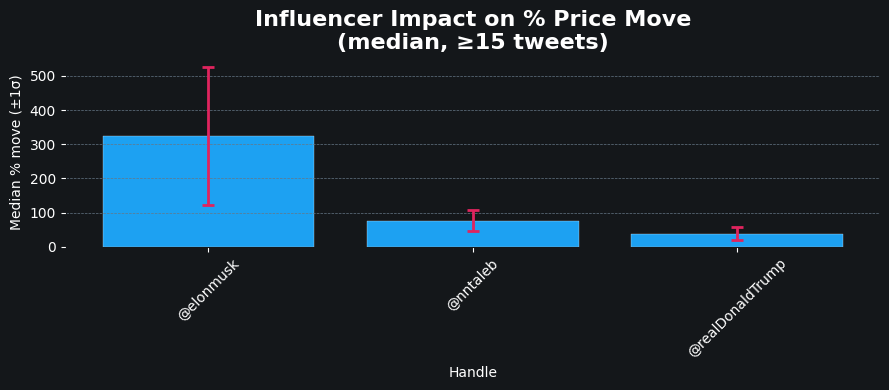

In [129]:
#influencer bar chart
plot_influencer_bar(top_n=4)

# Contagion Heat Map Plot

In [130]:
from matplotlib.colors import LinearSegmentedColormap

# build once and reuse
PINK  = '#E0245E'
BLUE  = '#1DA1F2'
pink_blue = LinearSegmentedColormap.from_list('pink_blue', [PINK, BLUE])

def plot_sector_heatmap(top_n=30, window_min=30):
    sector_map = {
        'AAPL':'Tech','MSFT':'Tech','GOOGL':'Tech',
        'TSLA':'Auto','NIO':'Auto',
        'BAC':'Finance','JPM':'Finance','C':'Finance','GS':'Finance','WFC':'Finance',
        'LMT':'Defense','NOC':'Defense','LDOS':'Defense',
        'KO':'Consumer','DIS':'Media','PINS':'Media','SNAP':'Media','FOX':'Media',
        'BTC':'Crypto','ETH':'Crypto'
    }

    ids, frames = altA.head(top_n)['tweet_id'], []
    for tid in ids:
        t0  = volatility_df.loc[volatility_df['tweet_id']==tid,'timestamp'].iloc[0]
        win = volatility_df[volatility_df['timestamp']
                 .between(t0-np.timedelta64(window_min,'m'),
                          t0+np.timedelta64(window_min,'m'))].copy()
        win['sector'] = win['ticker'].map(sector_map)
        win.dropna(subset=['sector'], inplace=True)
        pivot   = (win.groupby(['timestamp','sector'])['price']
                      .mean().unstack('sector'))
        returns = pivot.pct_change(fill_method=None)
        frames.append(returns)

    if not frames:
        print("No sector data for mapping"); return

    corr = pd.concat(frames).corr()

    fig, ax = plt.subplots(figsize=(7,6))
    im = ax.imshow(corr, vmin=-1, vmax=1, cmap=pink_blue)

    labels = corr.columns
    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=10)
    ax.set_yticklabels(labels, fontsize=10)

    # Annotate each cell with the correlation value
    for i in range(len(corr)):
        for j in range(len(corr)):
            val = corr.iloc[i, j]
            if not np.isnan(val):  # skip NaNs
                color = 'white' if abs(val) > 0.5 else 'black'
                ax.text(j, i, f"{val:.2f}", ha='center', va='center', fontsize=9, color=color)

    # Optional: set edge color for dark mode if BG is defined
    for spine in ax.spines.values():
        spine.set_color('white')  # or use BG if you defined it elsewhere

    fig.colorbar(im)
    ax.set_title(f"Sector Contagion (Top‑{top_n} Outlier Tweets)", fontsize=16, weight='bold')
    plt.tight_layout()
    plt.show()

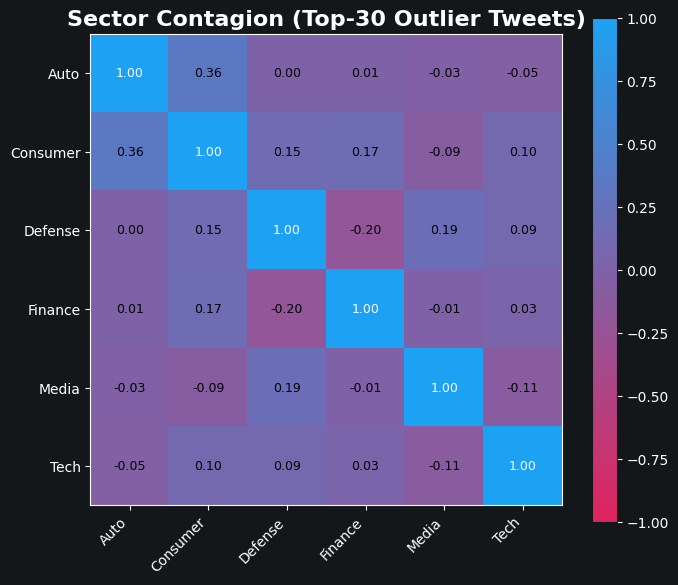

In [113]:
# (B) sector heat‑map from top‑30 Alt‑A tweets
plot_sector_heatmap(top_n=30)

# Timeline Plot

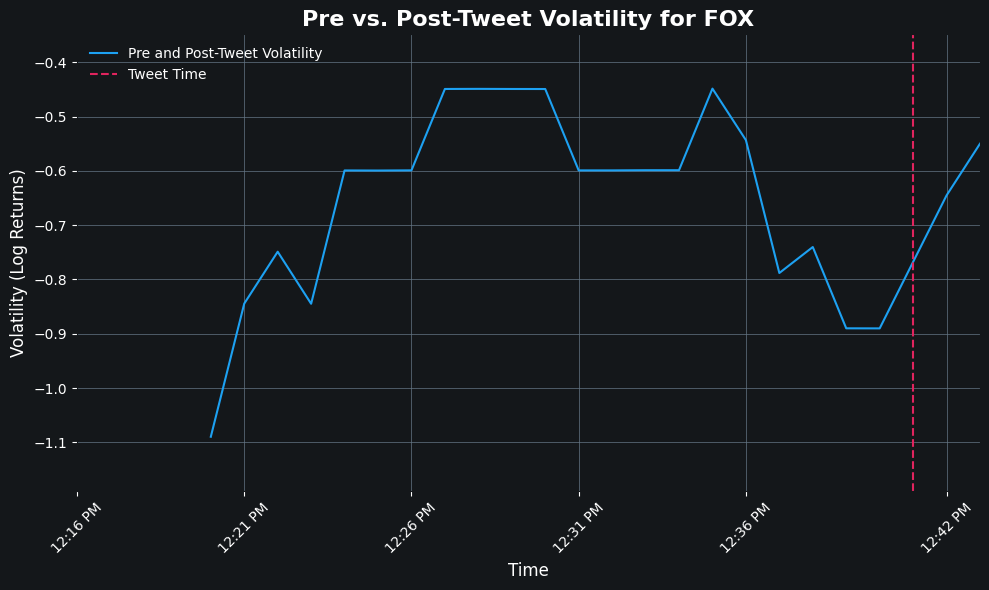

In [114]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def prepare_data_for_plotting(iloc_number, df):
    # Pick the tweet by its iloc index
    tweet = df.iloc[iloc_number]
    tweet_time = tweet['timestamp']
    ticker = tweet['ticker']

    # Get the price and volatility data for the specific ticker
    ticker_data = df[df['ticker'] == ticker].copy()

    # Ensure timestamp is datetime and sort data
    ticker_data['timestamp'] = pd.to_datetime(ticker_data['timestamp'])
    ticker_data = ticker_data.sort_values(by='timestamp')

    # Define a 30-minute span before and after the tweet
    start_time = tweet_time - np.timedelta64(30, 'm')
    end_time = tweet_time + np.timedelta64(30, 'm')
    time_window_data = ticker_data[(ticker_data['timestamp'] >= start_time) &
                                   (ticker_data['timestamp'] <= end_time)].copy()

    # Extract pre-tweet and post-tweet data for volatility comparison
    pre_tweet_data = time_window_data[time_window_data['timestamp'] < tweet_time]
    post_tweet_data = time_window_data[time_window_data['timestamp'] > tweet_time]

    # Calculate volatility for the periods
    pre_tweet_volatility = pre_tweet_data['log_return'].std()  # Standard deviation as volatility measure
    post_tweet_volatility = post_tweet_data['log_return'].std()  # Standard deviation as volatility measure

    # Combine the pre-tweet and post-tweet data
    combined_data = pd.concat([pre_tweet_data, post_tweet_data])

    return pre_tweet_data, post_tweet_data, pre_tweet_volatility, post_tweet_volatility, tweet_time, ticker, combined_data

def plot_volatility_comparison(pre_tweet_data, post_tweet_data, pre_tweet_volatility, post_tweet_volatility, tweet_time, ticker, combined_data):
    # Interpolate missing data points if there are any gaps in the log_return values
    combined_data['log_return'] = combined_data['log_return'].interpolate()

    # Smooth the combined data with a rolling average (using window of 5 points for example)
    combined_data['smoothed_log_return'] = combined_data['log_return'].rolling(window=5).mean()

    # Create figure and axes with navy background
    fig, ax = plt.subplots(figsize=(10, 6), facecolor='#14171A')
    ax.set_facecolor('#14171A')

    # Plot combined volatility line in lighter blue
    ax.plot(combined_data['timestamp'], combined_data['smoothed_log_return'],
            label=f"Pre and Post-Tweet Volatility", color='#1DA1F2', linestyle='-', linewidth=1.5)

    # Add vertical dashed line (Pink) at the time of the tweet
    ax.axvline(x=tweet_time, color='#E0245E', linestyle='--', label="Tweet Time")

    # Set title and axis labels in white
    ax.set_title(f"Pre vs. Post-Tweet Volatility for {ticker}", fontsize=16, fontweight='bold', color='white')
    ax.set_xlabel("Time", fontsize=12, color='white')
    ax.set_ylabel("Volatility (Log Returns)", fontsize=12, color='white')

    # Set x-axis ticks: every 5th timestamp in hh:mm AM/PM format
    tick_positions = combined_data['timestamp'][::5]
    tick_labels = [time.strftime('%I:%M %p') for time in combined_data['timestamp'][::5]]
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels, rotation=45, fontsize=10, color='white')

    # Set y-axis tick labels to white
    ax.tick_params(axis='y', colors='white')
    ax.tick_params(axis='x', colors='white')

    # Dynamically adjust the x-axis limits to fit the entire time range
    ax.set_xlim([combined_data['timestamp'].min(), combined_data['timestamp'].max()])

    # Dynamically adjust the y-axis limits based on the volatility data
    ax.set_ylim([combined_data['smoothed_log_return'].min() - 0.1, combined_data['smoothed_log_return'].max() + 0.1])

    # Set spines (borders) to navy so they blend with the background
    for spine in ax.spines.values():
        spine.set_color('#14171A')

    # Add subtle grid lines
    ax.grid(True, color='#657786', linestyle='-', linewidth=0.5)

    # Customize legend text to white
    leg = ax.legend(loc="upper left", fontsize=10, frameon=False)
    for text in leg.get_texts():
        text.set_color("white")

    plt.tight_layout()
    plt.show()

def plot_volatility_comparison_main(iloc_number, df):
    # Prepare data for plotting (pre-tweet/post-tweet data and pre-computed volatility)
    pre_tweet_data, post_tweet_data, pre_tweet_volatility, post_tweet_volatility, tweet_time, ticker, combined_data = prepare_data_for_plotting(iloc_number, df)

    # Plot the results
    plot_volatility_comparison(pre_tweet_data, post_tweet_data, pre_tweet_volatility, post_tweet_volatility, tweet_time, ticker, combined_data)

# Example usage: Replace `iloc_number` with the appropriate row index, and `df` with your dataframe
plot_volatility_comparison_main(100, volatility_df)
